In [2]:
%load_ext tensorboard

import random
from os import listdir
from os.path import join

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

writer = SummaryWriter("log")

### Data

In [3]:
!tar -xzf data.tar.gz
!echo $(ls data/train | wc -l) "Training images found"
!echo $(ls data/val | wc -l) "Validation images found"

2259 Training images found
450 Validation images found


In [4]:
class FrameDataset(Dataset):
  def __init__(self, data_dir):
    self.files = [join(data_dir, filepath) for filepath in listdir(data_dir)]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img = cv2.imread(self.files[idx])[:, :, [2, 1, 0]] / 255.0
    return img

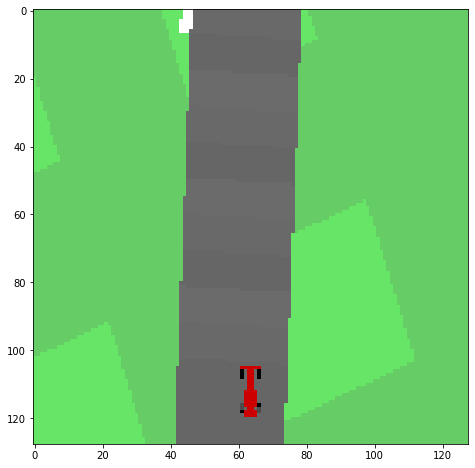

In [5]:
train_ds = FrameDataset("data/train")
val_ds = FrameDataset("data/val")
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(train_ds[0])
plt.show()

In [6]:
train_dataloader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=16, shuffle=True)

### Model

In [8]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, stride=2)
    self.conv2 = nn.Conv2d(16, 32, 4, stride=2)
    self.conv3 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv4 = nn.Conv2d(64, 128, 4, stride=2)
    self.conv5 = nn.Conv2d(128, 256, 4, stride=2)

  def forward(self, x):
    # channels first
    x = x.permute((0, 3, 1, 2))
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    return x

In [9]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2)
    self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2)
    self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2)
    self.deconv4 = nn.ConvTranspose2d(32, 16, 4, stride=2)
    self.deconv5 = nn.ConvTranspose2d(16, 3, 6, stride=2)

  def forward(self, x):
    x = F.relu(self.deconv1(x))
    x = F.relu(self.deconv2(x))
    x = F.relu(self.deconv3(x))
    x = F.relu(self.deconv4(x))
    x = self.deconv5(x)
    x = x.permute(0, 2, 3, 1)
    return x

In [10]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.dense_mu = nn.Linear(256*2*2, 256*2*2)
    self.dense_logvar = nn.Linear(256*2*2, 256*2*2)

  def forward(self, x):
    # Encoder
    x = self.encoder(x)

    # Reparametrization
    x = x.flatten(start_dim=1)
    mu = self.dense_mu(x)
    logvar = self.dense_logvar(x)  # logvar = log(sigma^2)
    epsilon = torch.randn_like(logvar)
    if x.is_cuda:
      epsilon = epsilon.to("cuda")
    x = epsilon * torch.exp(logvar * 0.5) + mu
    x = x.reshape(-1, 256, 2, 2)
    
    # Decoder
    x = torch.sigmoid(self.decoder(x))

    return x, mu, logvar

In [12]:
autoencoder = AutoEncoder()
device = torch.device("cuda")
autoencoder.to(device)
summary(autoencoder, input_size=(128, 128, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 63, 63]             784
            Conv2d-2           [-1, 32, 30, 30]           8,224
            Conv2d-3           [-1, 64, 14, 14]          32,832
            Conv2d-4            [-1, 128, 6, 6]         131,200
            Conv2d-5            [-1, 256, 2, 2]         524,544
           Encoder-6            [-1, 256, 2, 2]               0
            Linear-7                 [-1, 1024]       1,049,600
            Linear-8                 [-1, 1024]       1,049,600
   ConvTranspose2d-9            [-1, 128, 6, 6]         524,416
  ConvTranspose2d-10           [-1, 64, 14, 14]         131,136
  ConvTranspose2d-11           [-1, 32, 30, 30]          32,800
  ConvTranspose2d-12           [-1, 16, 62, 62]           8,208
  ConvTranspose2d-13          [-1, 3, 128, 128]           1,731
          Decoder-14          [-1, 128,

### Utility functions

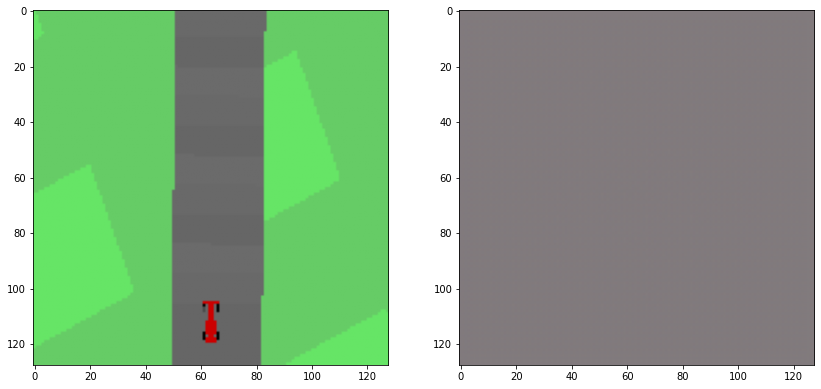

In [13]:
def show_example(model, dataset):
  fig, ax = plt.subplots(1, 2, figsize=(14, 10))
  idx = random.randint(0, len(dataset)-1)
  img = torch.from_numpy(dataset[idx])
  ax[0].imshow(img)
  with torch.no_grad():
    output, _, _ = model(img[None, :].float())
  ax[1].imshow(output[0])
  plt.show()

show_example(autoencoder.cpu(), train_ds)

### Model training

In [14]:
def vae_loss(inputs, reconstructed, mu, logvar, global_step=None):
  # Losses
  reconstruction_loss = F.binary_cross_entropy(reconstructed, inputs, reduction="sum")
  kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  
  # Weight
  start = 2000
  end = 10000
  if global_step is None:
    w = 1
  else:
    if global_step < start:
      w = 0
    elif global_step < end:
      w = (1/(end-start)) * (global_step-start)
    else:
      w = 1

  loss = reconstruction_loss + (0.1 * w * kld)

  # Tensorboard
  writer.add_scalar("w", w, global_step)
  writer.add_scalar("reconstruction", reconstruction_loss, global_step)
  writer.add_scalar("kld", kld, global_step)
  writer.add_scalar("loss", loss, global_step)

  return loss

In [15]:
N_EPOCHS = 100

criterion = vae_loss
autoencoder = AutoEncoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=3e-4)
device = torch.device("cuda")
history = []
val_history = []
global_steps = 0

for epoch in range(N_EPOCHS):
  running_loss = 0
  pbar = tqdm(train_dataloader)
  autoencoder.to(device)

  #############################
  # Training
  #############################
  for i, inputs in enumerate(pbar):
    optimizer.zero_grad()
    inputs = inputs.float().to(device)

    outputs, mu, logvar = autoencoder(inputs)
    loss = criterion(inputs, outputs, mu, logvar, global_steps)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    global_steps += 1
    pbar.set_description(f"epoch {epoch+1} - loss {running_loss / (i+1):.5f}")
  history.append(running_loss / (i+1))

  #############################
  # Validation
  #############################
  running_loss = 0
  with torch.no_grad():
    for j, inputs in enumerate(val_dataloader):
      inputs = inputs.float().to(device)
      outputs, mu, logvar = autoencoder(inputs)
      loss = criterion(inputs, outputs, mu, logvar, global_steps)
      running_loss += loss.item()
    val_history.append(running_loss / (j+1))

epoch 100 - loss 484304.30991: 100%|██████████| 142/142 [00:02<00:00, 47.56it/s]


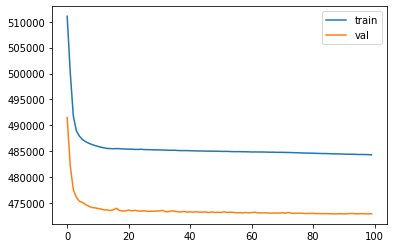

In [16]:
plt.plot(history, label="train")
plt.plot(val_history, label="val")
plt.legend()
plt.show()

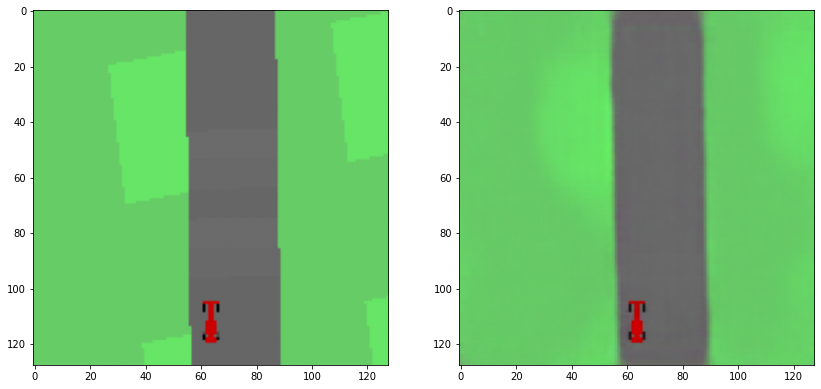

In [17]:
show_example(autoencoder.cpu(), val_ds)

In [20]:
import cv2
import numpy as np
from os import listdir

################################
# Stack Overflow
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)
################################

list_frames = sorted_alphanumeric(listdir("data/vid"))
n_frames = len(list_frames)
res = np.empty((n_frames, 256, 2*256, 3))

for i, frame in enumerate(tqdm(list_frames)):
  img = cv2.imread("data/vid/"+frame)
  img = img[:, :, [2, 1, 0]] / 255.0
  recon, _, _ = autoencoder(torch.from_numpy(img)[None, :].float())
  recon = recon.detach().numpy()[0]
  res[i, :, :256] = cv2.resize(img, (256, 256))
  res[i, :, 256:] = cv2.resize(recon, (256, 256))

res = (res*255).astype(np.uint8)

100%|██████████| 353/353 [00:03<00:00, 113.90it/s]


In [21]:
import imageio
imageio.mimsave('res.gif', res, fps=10)